<a href="https://colab.research.google.com/github/francoissouza/Winding-MMF-optimization/blob/main/%5BPresentation%5D_Winding_MMF_and_leakage_inductance_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Winding MMF Curve and End Winding Leakage Inductance Optimization 💡

Libraries import 📚

In [ ]:
# !pip install tqdm
%%capture
# !pip install kaleido
!pip install plotly>=4.0.0
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

import numpy as np
import pandas as pd
import pdb
import math
import cmath
from fractions import Fraction
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm 
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy import signal
# from google.colab import drive
# drive.mount('/gdrive')

%load_ext google.colab.data_table
%pdb off

import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import csv
from pickle import TRUE

Winding Distribution Table (WDT) and End Winding Leakage Inductante ($L_{ew}$) 💻

In [ ]:
class winding:
  def __init__(self, m, N, p, n_lay, y, n_es, parallel, n_coeff, compute_star, compute_MMF):
    try:
      self.error = ""
      self.m = m; self.N = N; self.p = p; self.n_lay = n_lay; self.y = y; self.n_es = n_es; self.parallel = parallel; self.n_coeff = n_coeff
      self.Q =  Fraction(self.N / (2*self.p*self.m)).limit_denominator(1000) * (n_es > 0)
      self.q = Fraction((self.N-self.n_es) / (2 * self.p * self.m)).limit_denominator(1000)
      self.a = math.floor(self.q)
      self.z = int(self.n_lay * self.p * (self.q - self.a))
      self.condition_1 = self.n_lay * (self.N - self.n_es) / (2 * self.m)
      self.t = math.gcd((self.N), self.p)
      self.sys_type = self.compute_type()
      self.condition_2 = ((self.N)/(self.m*self.t))*(self.sys_type == "Normal" or self.sys_type == "Non-reduced") + ((self.N)/(2*self.m*self.t))*(self.sys_type == "Reduced")
      self.zeta = ((self.m-1)/2)*(self.sys_type == "Normal") + ((self.m/2)-1)*(self.sys_type == "Non-reduced") + (0)*(self.sys_type == "Reduced")
      self.alpha_ph = (360/self.m)*(self.sys_type == "Normal" + self.sys_type == "Non-reduced") + (180/self.m)*(self.sys_type == "Reduced")
      self.t_line = math.gcd(self.z, self.p)*(self.n_es <= 0) + (1)*(self.n_es > 0)
      self.N_line = int(self.N/self.t_line)
      self.p_line = int(self.p/self.t_line)
      self.alpha_g = 180/self.m
      self.m_u = self.gpf(self.m) # Number of phases of subsystem groups that compound a reduced winding
      self.m_g = int(self.m/self.m_u) # Number of subsystems that compound a reduced winding
      self.alpha = self.t*360/self.N
      self.WDT = 0
      self.phi_k = np.array([slot*self.alpha for slot in np.arange(self.N * self.n_lay)])
      self.star_of_slots = np.zeros((self.m, 2))
      self.symmetric_star = False
      self.winding_scheme = np.zeros((self.n_lay, self.N))
      self.feasible = self.is_feasible()
      self.MMF_slots = 0
      self.MMF_phases = 0
      self.MMF = 0
      self.THD = 1000
      self.parallel_possibles = []
      self.parallel_possible = False
      self.k_d1 = 0
      self.k_p1 = 0
      self.star_raw = []
      self.Tau_s = 10 / 1000
      self.b_c_plus_t_e = 5 / 1000
      self.p_Tau_p = 0
      self.l_e_1 = 0
      self.l_e_2 = 15/1000
      self.n_s = 2 * self.m * self.parallel / self.N
      self.L_ew_slot = 0
      self.L_ew = 1000
      self.star_elem_to_plot = []
    
    except:
      self.feasible = False
      self.feasible_and_symmetric = False
      self.THD = 1000
      self.L_ew = 1000
      self.condition_1 = 0
      self.condition_2 = 0


    if self.feasible:
      self.star_elements = np.zeros((self.m, int(self.n_lay * (self.N)/self.m), 2))
      self.WDT = self.compute_WDT()
      self.compute_winding_scheme()
      if compute_star:
        self.compute_star_of_slots()
      if compute_MMF:
        self.compute_MMF()
    else:
      self.error += str("The winding is not feasible.\n" + "Condition 1:" + str(self.condition_1) + "\nCondition 2:" + str(self.condition_2))
    self.feasible_and_symmetric = self.feasible and self.symmetric_star

  def update(self, m, N, p, n_lay, y, n_es, n_coeff):
    self.error = ""
    self.m = m; self.N = N; self.p = p; self.n_lay = n_lay; self.y = y; self.n_es = n_es; self.n_coeff = n_coeff
    self.Q =  Fraction(self.N / (2*self.p*self.m)).limit_denominator(1000) * (n_es > 0)
    self.q = Fraction((self.N-self.n_es) / (2 * self.p * self.m)).limit_denominator(1000)
    self.a = math.floor(self.q)
    self.z = int(self.n_lay * self.p * (self.q - self.a))
    self.condition_1 = self.n_lay * (self.N - self.n_es) / (2 * self.m)
    self.t = math.gcd((self.N), self.p)
    self.sys_type = self.compute_type()
    self.condition_2 = ((self.N)/(self.m*self.t))*(self.sys_type == "Normal" or self.sys_type == "Non-reduced") + ((self.N)/(2*self.m*self.t))*(self.sys_type == "Reduced")
    self.zeta = ((self.m-1)/2)*(self.sys_type == "Normal") + ((self.m/2)-1)*(self.sys_type == "Non-reduced") + (0)*(self.sys_type == "Reduced")
    self.alpha_ph = (360/self.m)*(self.sys_type == "Normal" + self.sys_type == "Non-reduced") + (180/self.m)*(self.sys_type == "Reduced")
    self.t_line = math.gcd(self.z, self.p)*(self.n_es <= 0) + (1)*(self.n_es > 0)
    self.N_line = int(self.N/self.t_line)
    self.p_line = int(self.p/self.t_line)
    self.alpha_g = 180/self.m
    self.m_u = self.gpf(self.m) # Number of phases of subsystem groups that compound a reduced winding
    self.m_g = int(self.m/self.m_u) # Number of subsystems that compound a reduced winding
    self.alpha = self.t*360/self.N
    self.WDT = 0
    self.phi_k = np.array([slot*self.alpha for slot in np.arange(self.N * self.n_lay)])
    self.star_of_slots = np.zeros((self.m, 2))
    self.symmetric_star = False
    self.winding_scheme = np.zeros((self.n_lay, self.N))
    self.feasible = self.is_feasible()
    self.MMF_slots = 0
    self.MMF_phases = 0
    self.MMF = 0
    self.THD = 1000000
    self.star_elem_to_plot = []

    if self.feasible:
      self.star_elements = np.zeros((self.m, int(self.n_lay * (self.N)/self.m), 2))
      self.WDT = self.compute_WDT()
      self.compute_winding_scheme()
      self.compute_star_of_slots()
      self.compute_MMF()
    else:
      self.error += str("The winding is not feasible.\n" + "Condition 1:" + str(self.condition_1) + "\nCondition 2:" + str(self.condition_2))

    self.feasible_and_symmetric = self.feasible and self.symmetric_star

  def is_feasible(self): # Verify if the machine is feasible
    if self.n_es >= self.N:
      self.error += " There are more empty slots than the total slots disponible."
      return False
    return (self.condition_1 % 1 == 0) and (self.condition_2 % 1 == 0)

  def compute_type(self): # Machine type: Normal, Non-reduced or Reduced
    if (self.m % 2):
      return "Normal"
    elif not(self.m % 2) and (self.m % 3 == 0):
      return "Non-reduced"
    return "Reduced"

  def gpf(self, n): # Find the largest prime factor
    maxPrime = -1
    while n % 2 == 0:
        maxPrime = 2
        n >>= 1
    for i in range(3, int(math.sqrt(n)) + 1, 2):
        while n % i == 0:
            maxPrime = i
            n = n / i
    if n > 2:
        maxPrime = n  
    return int(maxPrime)

  def print_error(self):
    print(self.error)

  def compute_WDT(self): # Compute the Winding Distribution Table (WDT)
    if self.feasible:
      for k in np.arange(1, self.t_line + 1): # Compute the primitie WDT form
        j = 0
        while (self.N_line + j) % self.m != 0:
          j += 1
        WDT_base = np.zeros(self.N_line + j)
        i = 0
        for slot in np.arange((k-1)*self.N_line + 1, k*self.N_line + 1):
          while WDT_base[i] != 0:
            i = (i + 1)*(i < (self.N_line-1)) + (i-self.N_line) * (i >= (self.N_line-1))
          WDT_base[i] = slot
          i += (self.p_line)
          while i >= self.N_line:
            i = (i)*(i < (self.N_line)) + (i-self.N_line)*(i >= (self.N_line))
        WDT_base = WDT_base.reshape((self.m, int(np.size(WDT_base)/self.m)))
        try:
          WDT_23 = np.hstack((WDT_23, WDT_base[:, : math.ceil((self.N_line-self.n_es)/(2*self.m))]))
          WDT_14 = np.hstack((WDT_14, WDT_base[:, math.ceil((self.N_line-self.n_es)/(2*self.m)) :]))
        except:
          WDT_23 = WDT_base[:, : math.ceil((self.N_line-self.n_es)/(2*self.m))]
          WDT_14 = WDT_base[:, math.ceil((self.N_line-self.n_es)/(2*self.m)) :]
      WDT = np.hstack((WDT_23, WDT_14))
      if self.sys_type == "Normal" or self.sys_type == "Non-reduced":
        if self.n_es > 0:
          WDT = np.hstack((WDT_23, WDT_14))
          WDT_23 = WDT[:, : math.ceil((self.N - self.n_es)/(2*self.m))]
          WDT_14 = WDT[:, math.ceil((self.N - self.n_es)/(2*self.m)) : -math.ceil(self.n_es/self.m)]
        if np.size(WDT_14) != 0:
          WDT_14 = - np.roll(WDT_14, - int(self.zeta*np.size(WDT_14, 1)))
          self.WDT_1lay = np.hstack((WDT_23, WDT_14))
          if self.n_lay == 2:
            WDT_23_2lay = np.where(((abs(WDT_23)+self.y)//self.N > 0) , (abs(WDT_23)+self.y) % self.N, (abs(WDT_23)+self.y))
            WDT_23_2lay = np.where(WDT_23_2lay == 0, self.N, WDT_23_2lay)
            WDT_23_2lay = - np.sign(WDT_23)*WDT_23_2lay
            WDT_14_2lay = np.where(((abs(WDT_14)+self.y)//self.N > 0) , (abs(WDT_14)+self.y) % self.N, (abs(WDT_14)+self.y))
            WDT_14_2lay = np.where(WDT_14_2lay == 0, self.N, WDT_14_2lay)
            WDT_14_2lay = - np.sign(WDT_14)*WDT_14_2lay
            WDT_23 = np.hstack((WDT_23, WDT_23_2lay))
            WDT_14 = np.hstack((WDT_14, WDT_14_2lay))
            self.WDT_2lay = np.hstack((WDT_23_2lay, WDT_14_2lay))
          WDT = np.hstack((WDT_23, WDT_14))
        else:
          if self.n_lay == 2:
            WDT_23_2lay = np.where(((abs(WDT_23)+self.y)//self.N > 0) , (abs(WDT_23)+self.y) % self.N, (abs(WDT_23)+self.y))
            WDT_23_2lay = np.where(WDT_23_2lay == 0, self.N, WDT_23_2lay)
            WDT_23_2lay = - np.sign(WDT_23)*WDT_23_2lay
            WDT_23 = np.hstack((WDT_23, WDT_23_2lay))
            self.WDT_2lay = WDT_23_2lay
          self.WDT_1lay = WDT_23
          WDT = WDT_23
      if self.sys_type == "Reduced":
        if self.n_es > 0:
          WDT = np.hstack((WDT_23, WDT_14))
          WDT_23 = WDT[:, : math.ceil((self.N - self.n_es)/(2*self.m))]
          WDT_14 = WDT[:, math.ceil((self.N - self.n_es)/(2*self.m)) : -math.ceil(self.n_es/self.m)]
        if np.size(WDT_14) != 0:
          if np.size(WDT_23, axis=1) > np.size(WDT_14, axis=1):
            WDT_14 = np.pad(WDT_14, ((0,0),(0,np.size(WDT_23, axis=1) - np.size(WDT_14, axis=1))), mode="constant", constant_values=0.5)
          WDT_23_sup, WDT_23_inf = np.split(WDT_23, 2, 0)
          WDT_14_sup, WDT_14_inf = np.split(WDT_14, 2, 0)
          WDT_23 = np.vstack((WDT_23_sup, WDT_14_sup))
          WDT_14 = np.vstack((- WDT_23_inf, - WDT_14_inf))
          if self.m_u != 2:
            even_phases = 1
            for n in np.arange(self.m_u * self.m_g):
              if not even_phases % 2:
                WDT_23[n] = - WDT_23[n]
                WDT_14[n] = - WDT_14[n]
              even_phases = (even_phases + 1) - (int(even_phases/self.m_u)*self.m_u)
          a = 0
          b = int(self.m/2)
          WDT_23_aux = np.zeros(np.shape(WDT_23))
          WDT_14_aux = np.zeros(np.shape(WDT_14))
          for j in np.arange(1, self.m + 1): # Merge matrix rows
            if j % 2:
              WDT_23_aux[j-1] = WDT_23[a]
              WDT_14_aux[j-1] = WDT_14[a]
              a += 1
            else:
              WDT_23_aux[j-1] = WDT_23[b]
              WDT_14_aux[j-1] = WDT_14[b]
              b += 1
          WDT_23 = WDT_23_aux
          WDT_14 = WDT_14_aux
          self.WDT_1lay = np.hstack((WDT_23, WDT_14))
          if self.n_lay == 2:
            WDT_23_2lay = np.where(((abs(WDT_23)+self.y)//self.N > 0) , (abs(WDT_23)+self.y) % self.N, (abs(WDT_23)+self.y))
            WDT_23_2lay = np.where(WDT_23_2lay == 0, self.N, WDT_23_2lay)
            WDT_23_2lay = - np.sign(WDT_23)*WDT_23_2lay
            WDT_14_2lay = np.where(((abs(WDT_14)+self.y)//self.N > 0) , (abs(WDT_14)+self.y) % self.N, (abs(WDT_14)+self.y))
            WDT_14_2lay = np.where(WDT_14_2lay == 0, self.N, WDT_14_2lay)
            WDT_14_2lay = - np.sign(WDT_14)*WDT_14_2lay
            WDT_23 = np.hstack((WDT_23, WDT_23_2lay))
            WDT_14 = np.hstack((WDT_14, WDT_14_2lay))
            self.WDT_2lay = np.hstack((WDT_23_2lay, WDT_14_2lay))
          WDT = np.hstack((WDT_23, WDT_14))
          WDT = np.where(WDT % 1 != 0, 0, WDT)
        else:
          if self.n_lay == 2:
            WDT_23_2lay = np.where(((abs(WDT_23)+self.y)//self.N > 0) , (abs(WDT_23)+self.y) % self.N, (abs(WDT_23)+self.y))
            WDT_23_2lay = np.where(WDT_23_2lay == 0, self.N, WDT_23_2lay)
            WDT_23_2lay = - np.sign(WDT_23)*WDT_23_2lay
            WDT_23 = np.hstack((WDT_23, WDT_23_2lay))
            self.WDT_2lay = WDT_23_2lay
          self.WDT_1lay = WDT_23
          WDT = WDT_23
    return WDT

  def compute_star_of_slots(self): # Compute the Star of Slots and Star Symmetry
    for ph in np.arange(self.m):
      for i in np.arange(np.size(self.WDT, axis=1)):
        self.star_elements[int(ph), int(i), 0] = np.cos(((np.sign(self.WDT[int(ph), int(i)]) < 0)*180 + self.phi_k[int(abs(self.WDT[int(ph), int(i)])-1)])* np.pi/180)
        self.star_elements[int(ph), int(i), 1] = np.sin(((np.sign(self.WDT[int(ph), int(i)]) < 0)*180 + self.phi_k[int(abs(self.WDT[int(ph), int(i)])-1)])* np.pi/180)

      self.star_of_slots[ph] = np.sum(self.star_elements[ph], axis=0)

    self.star_elem_to_plot = self.star_elements
    for ph in np.arange(self.m):
      for i in np.arange(1, np.size(self.WDT, axis=1)):
        self.star_elem_to_plot[int(ph), int(i), 0] = self.star_elem_to_plot[int(ph), int(i-1), 0] + self.star_elem_to_plot[int(ph), int(i), 0]
        self.star_elem_to_plot[int(ph), int(i), 1] = self.star_elem_to_plot[int(ph), int(i-1), 1] + self.star_elem_to_plot[int(ph), int(i), 1]

    self.star_raw = self.phi_k

    magnitude = np.array([np.linalg.norm(self.star_of_slots[ph]) for ph in np.arange(self.m)])
    comp = np.array([complex(self.star_of_slots[ph,0], self.star_of_slots[ph,1]) for ph in np.arange(self.m)])
    angle = np.angle(comp,deg=True)
    angle = np.round(angle, 4)
    angle.sort()
    target_angle = (360/self.m)*(self.sys_type == "Normal" or self.sys_type == "Non-reduced") + (180/self.m)*(self.sys_type == "Reduced")
    self.symmetric_star = True
    if self.m == 1:
      if (np.size(self.WDT > 0) != np.size(self.WDT < 0)):
        self.symmetric_star = False
        self.error += " This single-phase winding have not coil side conductor symmetry."
    else:
      for d in np.arange(np.size(angle)-1):
        if not(math.isclose(target_angle, np.diff(angle)[d], rel_tol=1e-02, abs_tol=1e-02)) and not(math.isclose(target_angle, 360 - np.diff(angle)[d], rel_tol=1e-02, abs_tol=1e-02)):
          self.symmetric_star = False
          self.error += " This winding have not symmetric EMF (divergence in phasor angles)."
        if not math.isclose(0, np.diff(magnitude)[d], rel_tol=1e-02, abs_tol=1e-02):
          self.symmetric_star = False
          self.error += " This winding have not symmetric EMF (divergence in magnitude of phasors)."
      if np.all(self.star_of_slots <= 1e-02):
        self.symmetric_star = False
        self.error = " No EMF produced because in this winding all phasors are zero"

    self.k_d1 = (np.sqrt(np.sum(np.power(self.star_of_slots[0], 2)))) / (self.star_elem_to_plot[0,:,0].size)

    if self.n_lay == 1:
      cond = True
      i = 0
      while cond:
        if self.WDT[0, i] < 0:
          neg = self.WDT[0, i]
          cond = False
        else:
          i = i + 1
      pitch = np.abs(neg) - 1
    if self.n_lay == 2:
      pitch = self.y

    V_kp = np.array([[0.0, 0.0], [0.0, 0.0]])
    V_kp[0] = [1, 0]
    V_kp[1, 0] = np.cos((self.phi_k[int(pitch)])* np.pi/180)
    V_kp[1, 1] = np.sin((self.phi_k[int(pitch)])* np.pi/180)

    self.k_p1 = (math.sqrt(np.power(V_kp[0, 0] - V_kp[1, 0], 2) + np.power(V_kp[0, 1] - V_kp[1, 1], 2))) / (2)

    self.l_e_1 = (pitch * self.Tau_s * self.b_c_plus_t_e) / (2 * np.sqrt(self.Tau_s ** 2 - self.b_c_plus_t_e ** 2))

    self.L_ew_slot = 4 * np.pi * 10 ** (-7) * self.k_d1 ** 2 * self.k_p1 ** 2 * self.n_s ** 2 * (2.4) * (self.l_e_2 + self.l_e_1 / 2)
    self.L_ew = 9.6 / self.N * self.m * 4 * np.pi * 10 ** (-7) * self.k_d1 ** 2 * self.k_p1 ** 2 * (self.l_e_2 + self.l_e_1 / 2)

  def plot_star_and_scheme(self):
      fig1 = go.Figure(layout=go.Layout(title=go.layout.Title(text="Estrela de Fasores")))
      fig2 = go.Figure(layout=go.Layout(title=go.layout.Title(text="Conductors arrangement of first layer")))
      fig3 = go.Figure(layout=go.Layout(title=go.layout.Title(text="Conductors arrangement of second layer")))
      if n_lay == 1:
        tabel_colors = [px.colors.qualitative.Light24[abs(int(e[0]))-1]*(abs(int(e[0]))>0) + "white"*(abs(int(e[0]))<=0) for e in np.transpose(self.winding_scheme)]
      else:
        tabel_colors = [[px.colors.qualitative.Light24[abs(int(e[0]))-1]*(abs(int(e[0]))>0) + "white"*(abs(int(e[0]))<=0), px.colors.qualitative.Light24[abs(int(e[1]))-1]*(abs(int(e[1]))>0) + "white"*(abs(int(e[1]))<=0)] for e in np.transpose(self.winding_scheme)]
      fig4 = go.Figure(data=[go.Table(header=dict(values=np.arange(1, self.N+1), align='center'), cells=dict(values=np.transpose(self.winding_scheme), fill_color=tabel_colors, font=dict(color='white')))])

      for ph in np.arange(self.m):
        fig1.add_trace(go.Scatter(x=np.hstack(([0],self.star_elem_to_plot[ph,:,0])), y=np.hstack(([0],self.star_elem_to_plot[ph,:,1])), line = dict(dash='dot', color=px.colors.qualitative.Light24[ph]), name="FEM das boinas da fase " + str(ph+1)))
        fig1.add_trace(go.Scatter(x=[0, self.star_of_slots[ph, 0]], y=[0, self.star_of_slots[ph, 1]], line = dict(color=px.colors.qualitative.Light24[ph]) , name="Fasor resultante da fase " + str(ph+1)))
        fig2.add_trace(go.Scatter(mode="markers", marker_symbol=6, marker=dict(size=10, opacity=1, color=px.colors.qualitative.Light24[ph]), x=abs(self.WDT_1lay[ph,np.where(self.WDT_1lay[ph] < 0)[0]]), y=abs(np.zeros(np.shape(self.WDT_1lay[ph,np.where(self.WDT_1lay[ph] < 0)[0]]))),name="Positive EMF " + str(ph+1)))
        fig2.add_trace(go.Scatter(mode="markers", marker_symbol=5, marker=dict(size=10, opacity=1, color=px.colors.qualitative.Light24[ph]), x=abs(self.WDT_1lay[ph,np.where(self.WDT_1lay[ph] > 0)[0]]), y=abs(np.zeros(np.shape(self.WDT_1lay[ph,np.where(self.WDT_1lay[ph] > 0)[0]]))), name="Negative EMF " + str(ph+1)))
        try:
          fig3.add_trace(go.Scatter(mode="markers", marker_symbol=6, marker=dict(size=10, opacity=1, color=px.colors.qualitative.Light24[ph]), x=abs(self.WDT_2lay[ph,np.where(self.WDT_2lay[ph] < 0)[0]]), y=abs(np.zeros(np.shape(self.WDT_2lay[ph,np.where(self.WDT_2lay[ph] < 0)[0]]))),name="Positive EMF " + str(ph+1)))
          fig3.add_trace(go.Scatter(mode="markers", marker_symbol=5, marker=dict(size=10, opacity=1, color=px.colors.qualitative.Light24[ph]), x=abs(self.WDT_2lay[ph,np.where(self.WDT_2lay[ph] > 0)[0]]), y=abs(np.zeros(np.shape(self.WDT_2lay[ph,np.where(self.WDT_2lay[ph] > 0)[0]]))), name="Negative EMF " + str(ph+1)))
        except:
          pass
        for cond in np.arange((self.N-self.n_es)/self.m):
          fig2.add_vline(x=abs(self.WDT_1lay[ph, int(cond)]), line_color=px.colors.qualitative.Light24[ph])
          try:
            fig3.add_vline(x=abs(self.WDT_2lay[ph, int(cond)]), line_color=px.colors.qualitative.Light24[ph])
          except:
            pass
      slots_to_plot = np.arange(1, self.N+1)
      if self.n_lay == 2:
        slots_to_plot = np.hstack((np.arange(1, self.N+1), np.arange(1, self.N+1)))
      cond_to_plot = self.winding_scheme.reshape(1, np.size(self.winding_scheme))
      fig1.update_yaxes(scaleanchor = "x", scaleratio = 1)
      fig1.update_xaxes(visible=False)
      fig1.update_yaxes(visible=False)
      fig1.update_layout(plot_bgcolor="#FFFFFF")

      fig1.show()
      fig2.update_yaxes(scaleanchor = "x", scaleratio = 1)
      fig2.update_xaxes(nticks=self.N)
      fig2.update_layout(xaxis_title="Slots", yaxis_title="Conductor current direction of first layer")
      fig2.update_layout(plot_bgcolor="#FFFFFF")
      fig2.show()
      if n_lay == 2:
        fig3.update_yaxes(scaleanchor = "x", scaleratio = 1)
        fig3.update_xaxes(nticks=self.N)
        fig3.update_layout(xaxis_title="Slots", yaxis_title="Conductor current direction of second layer")
        fig3.update_layout(plot_bgcolor="#FFFFFF")
        fig3.show()
      fig4.update_layout(xaxis_title="Slots", yaxis_title="Winding Scheme")
      fig4.show()

  def compute_winding_scheme(self):
    if self.feasible:
      for ph in np.arange(self.m):
        for i in np.arange(0, (self.N-self.n_es) / self.m):
          self.winding_scheme[0, int(abs(self.WDT_1lay[int(ph), int(i)])-1)] = np.sign(self.WDT_1lay[int(ph), int(i)])*(ph+1)
          if self.n_lay == 2:
            self.winding_scheme[1, int(abs(self.WDT_2lay[int(ph), int(i)])-1)] = np.sign(self.WDT_2lay[int(ph), int(i)])*(ph+1)
    else:
       self.error = " Is not possible compute the winding scheme because this configuration is not feaseble."

  def compute_MMF(self):
    if self.feasible:
      n_sample = self.N*100
      self.MMF_slots = np.zeros((self.m, self.N, n_sample))
      for m in np.arange(np.size(self.MMF_slots, axis=0)):
        for slot in np.arange(int(self.N)):
          MMF_1lay_aux = 0
          MMF_2lay_aux = 0
          if int(abs(self.winding_scheme[0, slot])) == (m+1):
            sawtooth = signal.sawtooth(2 * np.pi * np.linspace(0, 1, n_sample), 0)
            sawtooth = np.roll(sawtooth, int(slot*n_sample/self.N))
            MMF_1lay_aux = np.sign(self.winding_scheme[0, slot]) * sawtooth
          if self.n_lay == 2:
            if int(abs(self.winding_scheme[1, slot])) == (m+1):
              sawtooth = signal.sawtooth(2 * np.pi * np.linspace(0, 1, n_sample), 0)
              sawtooth = np.roll(sawtooth, int(slot*n_sample/self.N))
              MMF_2lay_aux = np.sign(self.winding_scheme[1, slot]) * sawtooth
            self.MMF_slots[m, slot] = MMF_1lay_aux + MMF_2lay_aux
          elif self.n_lay == 1:
            self.MMF_slots[m, slot] = MMF_1lay_aux            
      self.MMF_phases = np.array([np.sum(self.MMF_slots[m,:],axis=0) for m in np.arange(np.size(self.MMF_slots, axis=0))])
      for ph in np.arange(self.m):
        self.MMF_phases[ph] = (self.MMF_phases[ph]/np.max(abs(self.MMF_phases[ph])))*np.cos(ph*2*np.pi/self.m)
      self.MMF = np.sum(self.MMF_phases,axis=0)
      self.MMF = self.MMF/np.max(abs(self.MMF))
      self.fs = Fourier_Series(self.n_coeff, np.linspace(0, self.N, np.size(self.MMF)), self.MMF)
      self.THD = self.fs.THD
    else:
      self.error = " Is not possible compute the MMF because this configuration is not feaseble."

  def plot_MMF(self):
    if self.feasible:
      fig5 = go.Figure(layout=go.Layout(title=go.layout.Title(text="FMM do enrolamento")))
      for ph in np.arange(self.m):
        fig5.add_trace(go.Scatter(x=np.linspace(0, self.N, np.size(self.MMF)), y=self.MMF_phases[ph], line = dict(dash='dot', color=px.colors.qualitative.Light24[ph]) , name="FMM da fase " + str(ph+1)))
      fig5.add_trace(go.Scatter(x=np.linspace(0, self.N, np.size(self.MMF)), y=self.MMF, line = dict(color=px.colors.qualitative.Dark24[5]) , name="FMM do enrolamento"))
      fig5.update_xaxes(title_text='Ranhuras')
      fig5.update_yaxes(title_text='FMM normalizada em Ampére-espira (Ae)')
      fig5.update_layout(plot_bgcolor="#FFFFFF")

      fig5.update_layout(legend=dict(
          orientation="h",
          yanchor="bottom",
          y=1.02,
          xanchor="right",
          x=1
          ))

      fig6 = go.Figure(layout=go.Layout(title=go.layout.Title(text="Aproximação da FMM do enrolamento pela série de Fourier")))
      fig6.add_trace(go.Scatter(x=np.linspace(0, self.N, np.size(self.MMF)), y=self.MMF, line = dict(color=px.colors.qualitative.Dark24[5]) , name="FMM do enrolamento"))
      fig6.add_trace(go.Scatter(x=np.linspace(0, self.N, np.size(self.MMF)), y=self.fs.y, line = dict(color=px.colors.qualitative.Dark24[0]) , name="Aproximação pela série de Fourier"))
      fig6.update_xaxes(title_text='Ranhuras')
      fig6.update_yaxes(title_text='FMM normalizada em Ampére-espira (Ae)')
      fig6.update_layout(plot_bgcolor="#FFFFFF")

      fig6.update_layout(legend=dict(
          orientation="h",
          yanchor="bottom",
          y=1.02,
          xanchor="right",
          x=1
          ))
      fig5.show()
      fig6.show()

  def compute_possible_parallel_paths(self):
    n = self.WDT[0].size / 2
    cond = True
    while cond:
      self.parallel_possibles.append(n)
      if n % 2 == 0:
        n = n/2
      else:
        cond = False
    self.parallel_possibles = [int(a) for a in self.parallel_possibles]
    self.parallel_possibles = np.array(self.parallel_possibles)

  def is_parallel_possible(self):
    find = np.where(self.parallel_possibles == self.parallel)
    find = np.array(find)
    if find[0].size == 1:
      self.parallel_possible = True
    else:
      self.parallel_possible = False
      self.error += str("The number of parallel paths are invalid")


Total Harmonic Distortion 🔺

In [ ]:
class Fourier_Series:
  def __init__(self, n, x, y):
      self.compute_coeff(n, x, y)
      self.compute_fourier_series(n, x)
      self.compute_THD(n)

  def compute_coeff(self, n, x, y):
    L = (x[-1] - x[0])/2
    self.a0 = 1/L*integrate.simps(y, x)
    self.an = np.array([1/L*integrate.simps(y*np.cos(ni*np.pi*x/L), x) for ni in np.arange(1, n+1)])
    self.bn = np.array([1/L*integrate.simps(y*np.sin(ni*np.pi*x/L), x) for ni in np.arange(1, n+1)])

  def compute_fourier_series(self, n, x):
    L = (x[-1] - x[0])/2
    self.y = np.array([self.a0/2 + np.sum(np.array([self.an[ni-1]*np.cos(ni*np.pi*xi/L) + self.bn[ni-1]*np.sin(ni*np.pi*xi/L) for ni in np.arange(1, n+1)])) for xi in x]) 

  def compute_THD(self, n):
    self.harm = np.array([np.sqrt(self.an[i]**2 + self.bn[i]**2) for i in np.arange(n)])
    self.THD = np.sqrt(np.sum(self.harm**2) - np.max(self.harm)**2 ) / np.max(self.harm)

Try it yourself 🤓

In [ ]:
# ------------------------------------------------------------------------------
# Try the following code to compute the star-of-slots, the conductior direction 
# disposition for all layers and the table of winding schemes.
# ------------------------------------------------------------------------------

m = 3
N = 36
p = 2
n_lay = 2
y = 3
n_es = 0
parallel = 1
n_coeff = 200
compute_star = True
compute_MMF = True

wd = winding( m, N, p, n_lay, y, n_es, parallel, n_coeff, compute_star, compute_MMF)
wd.print_error()
print("THD =", wd.THD)
print("L_ew =", wd.L_ew)
wd.plot_star_and_scheme()
wd.plot_MMF()



THD = 0.11337523690943052
L_ew = 1.1188493537788368e-09


Multi-objective Particle Swarm Optimization 🏃

pop: 42 archive: 11 dominated: 31


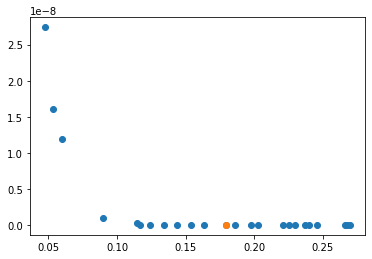

epoch 1, pop: 42, archive: 11, dominated: 31, out: 0, gbest_retention: 2, eph_mult_lim / gbest_retention = 10.0
epoch 2, pop: 42, archive: 12, dominated: 30, out: 25, gbest_retention: 3, eph_mult_lim / gbest_retention = 6.666666666666667
epoch 3, pop: 42, archive: 10, dominated: 32, out: 24, gbest_retention: 1, eph_mult_lim / gbest_retention = 20.0
epoch 4, pop: 42, archive: 11, dominated: 31, out: 23, gbest_retention: 1, eph_mult_lim / gbest_retention = 20.0
epoch 5, pop: 42, archive: 11, dominated: 31, out: 25, gbest_retention: 2, eph_mult_lim / gbest_retention = 10.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  


epoch 6, pop: 42, archive: 11, dominated: 31, out: 19, gbest_retention: 1, eph_mult_lim / gbest_retention = 20.0
epoch 7, pop: 42, archive: 11, dominated: 31, out: 28, gbest_retention: 2, eph_mult_lim / gbest_retention = 10.0
epoch 8, pop: 42, archive: 11, dominated: 31, out: 21, gbest_retention: 1, eph_mult_lim / gbest_retention = 20.0
epoch 9, pop: 42, archive: 11, dominated: 31, out: 26, gbest_retention: 2, eph_mult_lim / gbest_retention = 10.0
epoch 10, pop: 42, archive: 11, dominated: 31, out: 27, gbest_retention: 3, eph_mult_lim / gbest_retention = 6.666666666666667
epoch 11, pop: 42, archive: 11, dominated: 31, out: 26, gbest_retention: 4, eph_mult_lim / gbest_retention = 5.0
epoch 12, pop: 42, archive: 11, dominated: 31, out: 30, gbest_retention: 5, eph_mult_lim / gbest_retention = 4.0
epoch 13, pop: 42, archive: 11, dominated: 31, out: 24, gbest_retention: 6, eph_mult_lim / gbest_retention = 3.3333333333333335
epoch 14, pop: 42, archive: 11, dominated: 31, out: 28, gbest_reten

In [ ]:
# Case 04 - MOSPO
m = [3, 3]
N = [30, 150]
p = [1, 3]
n_lay = [1, 2]
y = [1, 4]
n_es = [0, 0]  

parallel = 1
n_coeff = 200

compute_star = True
compute_MMF = False

particles_ok = []
possible = (m[1] - m[0] + 1) * (N[1] - N[0] + 1) * (p[1] - p[0] + 1) * (n_lay[1] - n_lay[0] + 1) * (y[1] - y[0] + 1) * (n_es[1] - n_es[0] + 1)
for m1 in np.arange(m[0], m[1] + 1):
  for N1 in np.arange(N[0], N[1] + 1):
    for p1 in np.arange(p[0], p[1] + 1):
      for n_lay1 in np.arange(n_lay[0], n_lay[1] + 1):

        if n_lay1 == 2:
          for y1 in np.arange(y[0], y[1] + 1):
            for n_es1 in np.arange(n_es[0], n_es[1] + 1):
              wd = winding( m1, N1, p1, n_lay1, y1, n_es1, parallel, n_coeff, compute_star, compute_MMF)
              if wd.feasible_and_symmetric:
                particles_ok.append([m1, N1, p1, n_lay1, y1, n_es1])
        if n_lay1 == 1:
          y1 = 1
          for n_es1 in np.arange(n_es[0], n_es[1] + 1):
            wd = winding( m1, N1, p1, n_lay1, y1, n_es1, parallel, n_coeff, compute_star, compute_MMF)
            if wd.feasible_and_symmetric:
              particles_ok.append([m1, N1, p1, n_lay1, y1, n_es1])

# print("particles_ok = ", len(particles_ok))

compute_star = True
compute_MMF = True

# ---------- Function ----------
x_dim = 6
# x_lim = np.array([[0, 5], [0, 3]]) # Binh and Korn function
# x_lim = np.array([[-20, 20], [-20, 20]]) # Chankong and Haimes function
# x_lim = np.array([[0.1, 1], [0, 5]]) # Constr-Ex problem
x_lim = np.array([m, N, p, n_lay, y, n_es]) # MMF Optimization

def fit_func(x):
  # y = np.array([(4 * x[0] ** 2 + 4* x[1] ** 2), ((x[0] - 5) ** 2 + (x[1] + 5) ** 2)]) # Binh and Korn function
  # y = np.array([2 + (x[0] - 2) ** 2 + (x[1] - 1) ** 2, 9 * x[0] - (x[1] - 1) ** 2]) # Chankong and Haimes function
  # y = np.array([x[0], (1 + x[1]) / x[0] ])  # Constr-Ex problem
  wd = winding( x[0], x[1], x[2], x[3], x[4], x[5], parallel, n_coeff, compute_star, compute_MMF)  # MMF Optimization
  y = np.array([wd.THD, wd.L_ew])
  return y

def constraints(x):
  # c = np.array([((x[0] - 5) ** 2 + (x[1] ** 2) - 25), (-(x[0]-8)**2 - (x[1]-3)**2 + 7.7)]) # Binh and Korn function
  # c = np.array([x[0] ** 2 + x[1] ** 2 - 255 , x[0] - 3 * x[1] + 10])  # Chankong and Haimes function
  # c = np.array([- x[1] - 9 * x[0] + 6, x[1] - 9 * x[0] + 1]) # Constr-Ex problem
  wd = winding( x[0], x[1], x[2], x[3], x[4], x[5], parallel, n_coeff, compute_star, compute_MMF)
  if wd.feasible_and_symmetric:
    c = -1
  else:
    c = 1

  if (x[0] < m[0] or x[0] > m[1]) or (x[1] < N[0] or x[1] > N[1]) or (x[2] < p[0] or x[2] > p[1]) or (x[3] < n_lay[0] or x[3] > n_lay[1]) or (x[4] < y[0] or x[4] > y[1]) or (x[5] < n_es[0] or x[5] > n_es[1]) :
    c = 1

  return c

  

# ---------- MOPSO ----------

int_simulation = True
n_pop = int(len(particles_ok) * 10 / 100)    # Number of particles
pareto_max = n_pop   # Number of particles in Pareto Front
W = 0.4       # Weight parameter
c1 = 0.5          # Individual coefficient
c2 = 1            # Collective coefficient
k = 3             # Number of particles to takes into account in density computation
phi = 100         # Factor to multiply the fitness in case the particle violate the constraints
gbest_retention_lim = 4
gbest_retention = 1
gbest_keep = [0, 0]
eph = 0
eph_mult_lim = 20

def init_pop(n_pop, x_dim):
  pop = []
  gbest = []
  j = 1
  index = []
  while len(pop) < n_pop:
    # print(len(pop))
    pbest = 0
    fitness = []
    dominated = False
    density = 0
    is_pareto_front = False
    particle = [np.zeros(x_dim),  # 0 - Position
                np.zeros(x_dim),  # 1 - Velocity
                pbest,            # 2 - pbest
                fitness,          # 3 - fitness value
                dominated,        # 4 - is dominated?
                density]          # 5 - density value

    ind = round_number((len(particles_ok)) * np.random.random_sample())
    if ind == len(particles_ok):
      ind = ind - 1 
    while ind in index:
      ind = round_number((len(particles_ok)) * np.random.random_sample())
      if ind == len(particles_ok):
        ind = ind - 1
    index.append(ind)
    particle[0] = np.array(particles_ok[ind])

    for dim in np.arange(x_dim):
      if int_simulation:
        particle[1][dim] = round_number(particle[1][dim])
        particle[1] = particle[1].astype(int)
    if np.all(constraints(particle[0]) <= 0):
      particle[2] = particle[0]
      particle[3] = fit_func(particle[0])
      pop.append(particle)

  return pop

def dominated(pop):
  pop_aux = []
  for particle_tested in pop:
    particle_tested[4] = False
    for particles in pop:
      if np.all(particles[3] <= particle_tested[3]) and np.any(particles[3] < particle_tested[3]):
        particle_tested[4] = True
    pop_aux.append(particle_tested)
  pop = pop_aux
  return(pop)

def pareto_front(pareto_max, pop, gbest_retention, gbest_keep):
  archive = []
  dominated_pop = []
  dist = []
  for particle in pop:
    if particle[4] == False:
      add = True
      for elem in archive:
        if particle[3][0] == elem[3][0] and particle[3][1] == elem[3][1]:
          add = False
      if add:
        archive.append(particle)
      else:
        dominated_pop.append(particle)
    else:
      dominated_pop.append(particle)
  archive_aux = []
  for particle in archive:
    particle[5] = compute_dist(particle, archive)
    dist.append(particle[5])
    archive_aux.append(particle)
  archive = archive_aux
  dist = -np.array(dist)
  dist_mean = np.mean(dist)
  dist_ord = np.argsort(dist)
  archive_aux = []
  for i in np.arange(len(dist_ord)):
    archive_aux.append(archive[dist_ord[i]])
  archive = archive_aux
  archive_aux = []
  if len(archive) > pareto_max:
    for i in np.arange(pareto_max, len(archive)):
      dominated_pop.append(archive[i])
    archive = archive[:pareto_max]
  pop = archive + dominated_pop
  if eph == 0:
    gbest_keep = archive[0][3] 
  if archive[0][3][0] == gbest_keep[0] and archive[0][3][1] == gbest_keep[1]:
    gbest_retention = gbest_retention + 1
  else:
    gbest_retention = 1
    gbest_keep = archive[0][3]    
  gbest = archive [gbest_retention // gbest_retention_lim]
  return pop, archive, dominated_pop, gbest, gbest_retention, gbest_keep

def update_vel_and_pos(dominated_pop, gbest):
  pop = []
  for particle in dominated_pop:
    particle[1] = W * particle[1] + c1 * np.random.random_sample() * (particle[2] - particle[0]) + c2 * np.random.random_sample() * (gbest[0] - particle[0])
    if int_simulation:
      particle[1] = round_number(particle[1])
      particle[1] = particle[1].astype(int)
    particle[0] = particle[0] + particle[1]
    if int_simulation:
      particle[0] = round_number(particle[0])
      particle[0] = particle[0].astype(int)
    pop.append(particle)
  return pop

def compute_dist(particle, pop):
  distance = []
  density = 0
  for particles in pop:
    distance.append(np.sqrt(np.sum((particle[3] - particles[3]) ** 2)))
  distance = np.sort(np.array(distance))
  dens = np.mean(distance[1:k+1])
  return dens
    
def update_graph(x, y):
  plt.scatter(x, y)
  fig.canvas.draw()
  hfig.update(fig)

def round_number(x):
  return np.around(x, 0).astype(int)
  

# ----- Solution -----

pop = init_pop(n_pop, x_dim)
pop = dominated(pop)
pop, archive, dominated_pop, gbest, gbest_retention, gbest_keep = pareto_front(pareto_max, pop, gbest_retention, gbest_keep)
print("pop: " + str(len(pop)) + " archive: " + str(len(archive)) + " dominated: " + str(len(dominated_pop)) )
fig = plt.figure()
hfig = display(fig, display_id=True)
out = 0

while not(eph_mult_lim / gbest_retention == 1.0):
  print("epoch " + str(eph + 1) + ", pop: " + str(len(pop)) + ", archive: " + str(len(archive)) + ", dominated: " + str(len(dominated_pop)) + ", out: " + str(out)  + ", gbest_retention: " + str(gbest_retention) + ", eph_mult_lim / gbest_retention = " + str(eph_mult_lim / gbest_retention) )
  out = 0
  dominated_pop = update_vel_and_pos(dominated_pop, gbest) # Update the velocity and position of the dominated particles
  dominated_pop_aux = []
  for particle in dominated_pop: # Update the fitness value of particles
    old_fitness = particle[3]
    if np.all(constraints(particle[0]) <= 0):
      particle[3] = fit_func(particle[0])
    else:
      particle[3] = np.abs(constraints(particle[0])) * phi
      out = out + 1
    if np.all(particle[3] < old_fitness): # Update pbest
      particle[2] = particle[0]
    dominated_pop_aux.append(particle)
  dominated_pop = dominated_pop_aux
  pop = archive + dominated_pop
  pop = dominated(pop)
  pop, archive, dominated_pop, gbest, gbest_retention, gbest_keep = pareto_front(pareto_max, pop, gbest_retention, gbest_keep)

  plt.clf()
  f1 = []
  f2 = []  
  for elem in archive:
    f1.append(elem[3][0])
    f2.append(elem[3][1])
  update_graph(f1, f2)
  update_graph(gbest[3][0], gbest[3][1])
  eph = eph + 1

plt.close(fig)
pareto_front = []
for elem in archive:
  pareto_front.append( elem[0].tolist() + elem[3].tolist() )

# with open('/gdrive/MyDrive/Dissertação/Feasible and Simmetric/MOPSO.csv', 'w', encoding='UTF8', newline='') as f:
#   writer = csv.writer(f)
#   writer.writerows(pareto_front)
# f.close()

print("Finish")